### Raw data

* Number of users: 24 million
* Number of projects: 83 million
* Number of commits: 1 billion

In [1]:
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import cross_validation as cv
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from numpy.linalg import svd
from sklearn.metrics import mean_squared_error
from math import sqrt

/home/theofpa/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%%time
#df=pd.read_csv('/storage2/mysql-2018-04-01/commits.csv',header=None,usecols=['user','repo'],names=['id','sha','user1','user','repo','date'],na_values='\\N')
df=pd.read_csv('/storage2/mysql-2018-04-01/commits.csv',nrows=10000000,header=None,usecols=['user','repo'],names=['id','sha','user1','user','repo','date'],na_values='\\N')
df.dropna(inplace=True)
df['count']=1
df['repo']=df['repo'].astype('int32')

CPU times: user 4.72 s, sys: 578 ms, total: 5.3 s
Wall time: 5.3 s


In [3]:
%%time
ndf=df.groupby(['user','repo']).count()

CPU times: user 1.12 s, sys: 360 ms, total: 1.48 s
Wall time: 1.48 s


In [4]:
%%time
ndf=ndf.dropna()
#ndf=ndf[(ndf>3)&(ndf<40000)].dropna()
ndf['count']=ndf['count'].astype('int32')
ndf=ndf.reset_index()

CPU times: user 62.8 ms, sys: 20.7 ms, total: 83.4 ms
Wall time: 81.7 ms


In [ ]:
ndf.to_pickle('ndf.pkl')

In [32]:
# groupby&unstack seems to be faster than pivot_table
#ndf=ndf.unstack()

In [5]:
import sys
print('dataframe:',int(sys.getsizeof(df)/1024/1024),'MB, length: ', len(df))
print('filtered:',int(sys.getsizeof(ndf)/1024/1024),'MB, length: ',len(ndf))

dataframe: 267 MB, length:  9999819
filtered: 16 MB, length:  876270


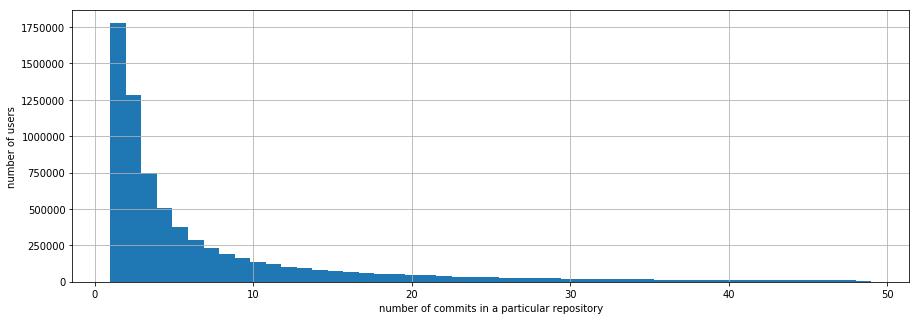

In [34]:
plt.rcParams["figure.figsize"] = [15,5]
ndf[ndf<50]['count'].hist(bins=49)
plt.xlabel('number of commits in a particular repository')
plt.ylabel('number of users');

### Two sides filtering
* Repo filtering: select the repo with more than 3 or 5 users commits
* User filtering: select the user with more than  3 or 5 repo commits. 

In [5]:
%%time
# index of popular repos (with commits from more than 3 different users):
repos=ndf.groupby('repo').count()
print(len(repos[repos['user']>4].index))

26162
CPU times: user 124 ms, sys: 12 ms, total: 136 ms
Wall time: 135 ms


In [6]:
%%time
# index of polymath users (with commits on more than 3 repositories):
users=ndf.groupby('user').count()
print(len(users[users['repo']>4].index))

38234
CPU times: user 58.9 ms, sys: 654 µs, total: 59.6 ms
Wall time: 57.7 ms


In [26]:
%%time
threshold=10
fdf=ndf[
    (ndf['user'].isin(users[users['repo']>threshold].index))
    &
    (ndf['repo'].isin(repos[repos['user']>threshold].index))
]

CPU times: user 33 ms, sys: 0 ns, total: 33 ms
Wall time: 32 ms


In [27]:
len(fdf)

30263

In [28]:
fdf=fdf.groupby(['user','repo']).count()
fdf['contributor']=1
#fdf['contributor']=fdf['contributor'].astype('bool')

In [29]:
fdf.drop(['count'],axis=1,inplace=True)

In [11]:
import sys
print('filtered:',int(sys.getsizeof(fdf)/1024/1024),'MB, length: ',len(fdf))

filtered: 0 MB, length:  30263


In [33]:
%%time
mf=fdf.unstack(fill_value=0)

CPU times: user 95.6 ms, sys: 63.8 ms, total: 159 ms
Wall time: 158 ms


In [12]:
mf.to_pickle('mf.pkl')

In [13]:
mf['contributor']=mf['contributor'].astype('bool')

In [110]:
%%time
sim = 1 - pairwise_distances(mf.T, metric = "jaccard")
sim = pd.DataFrame(sim, index=mf.columns, columns=mf.columns)

/home/theofpa/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


CPU times: user 27.8 s, sys: 144 ms, total: 27.9 s
Wall time: 27.9 s


In [34]:
%%time
sim = 1 - pairwise_distances(mf.T, metric = "cosine")
sim = pd.DataFrame(sim, index=mf.columns, columns=mf.columns)

CPU times: user 20.7 s, sys: 1.27 s, total: 22 s
Wall time: 2.73 s


In [35]:
sparsity=round(1.0-len(mf)/float(mf['contributor'].shape[0]*mf['contributor'].shape[1]),3)
print('The sparsity level of GitHub is '+ str(sparsity*100) + '%')

The sparsity level of GitHub is 100.0%


In [36]:
train_data, test_data = cv.train_test_split(mf, test_size=0.4)

In [71]:
%%time
user_similarity = pairwise_distances(train_data['contributor'].as_matrix(), metric='cosine')
item_similarity = pairwise_distances(train_data['contributor'].as_matrix().T, metric='cosine')

CPU times: user 13.8 s, sys: 2.48 s, total: 16.3 s
Wall time: 2.06 s


In [73]:
mean_user_rating=train_data['contributor'].as_matrix().mean(axis=1)

In [75]:
ratings_diff = (train_data['contributor'].as_matrix() - mean_user_rating[:, np.newaxis])

In [76]:
pred = mean_user_rating[:, np.newaxis] + user_similarity.dot(ratings_diff) / np.array([np.abs(user_similarity).sum(axis=1)]).T

In [77]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [79]:
print('User-based CF RMSE: ' + str(rmse(pred, test_data['contributor'].as_matrix())))

User-based CF RMSE: 0.9981825345683039


In [97]:
%%time
u, s, vh = np.linalg.svd(train_data['contributor'].as_matrix(), full_matrices=True)

CPU times: user 3min 50s, sys: 2min 8s, total: 5min 58s
Wall time: 32.5 s


In [109]:
%%time
X_pred = np.dot(u[:, :len(s)] * s, vh)
print('User-based CF MSE: ' + str(rmse(X_pred, test_data['contributor'].as_matrix())))

User-based CF MSE: 0.9986968556118937
CPU times: user 12.2 s, sys: 877 ms, total: 13.1 s
Wall time: 1.27 s
